# Анализ схожести научных текстов с помощью методов естественной обработки языка и машинного обучения
Береза Анастасия // Учебная группа о.ИЗДтс 23.2/Б3-22

## Установка зависимостей


In [ ]:
# При первом запуске раскомментировать строку ниже

# %pip install tensorflow kagglehub pandas numpy scikit-learn joblib tqdm psutil nltk pymorphy3 matplotlib torch

## Импорт библиотек


In [ ]:
import kagglehub
import os
import shutil

from pathlib import Path
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import tee

from typing import Dict, List

import pymorphy3
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm

import torch
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import random

f:\PDipPraktika\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cuda


In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Для GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    # Оотключение недетерминированных алгоритмов
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed fixed: {seed}")

In [ ]:
# import torch
# print(torch.__version__)
# print(torch.version.cuda)
# print(torch.cuda.is_available())


## Загрузка датасета

In [4]:
path = kagglehub.dataset_download("ergkerg/russian-scientific-articles")
print("Path to dataset files:", path)

# Копирование в папку проекта

destination_path = os.path.join(os.getcwd(), "russian-scientific-articles")
shutil.copytree(path, destination_path, dirs_exist_ok=True)

print("Файлы датасета перенесены в:", destination_path)

Path to dataset files: C:\Users\Basss\.cache\kagglehub\datasets\ergkerg\russian-scientific-articles\versions\1
Файлы датасета перенесены в: f:\PDipPraktika\russian-scientific-articles


## Сбор датасета и анализ набора данных

In [5]:
# Сбор датасета из txt-файлов

rows = []
for root in ["russian-scientific-articles/data_3_1", "russian-scientific-articles/data_3"]:
     for p in Path(root).rglob("*.txt"):
        rows.append({
              "category": p.parent.name,
              "file": str(p),
              "text": p.read_text(encoding="utf-8", errors="ignore")
        })

df = pd.DataFrame(rows)
df.shape


(2478, 3)

In [ ]:
df.head(5)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df['text'].describe(include='all')

In [ ]:
df.drop_duplicates(['text',], inplace=True)
df['text'].describe(include='all')

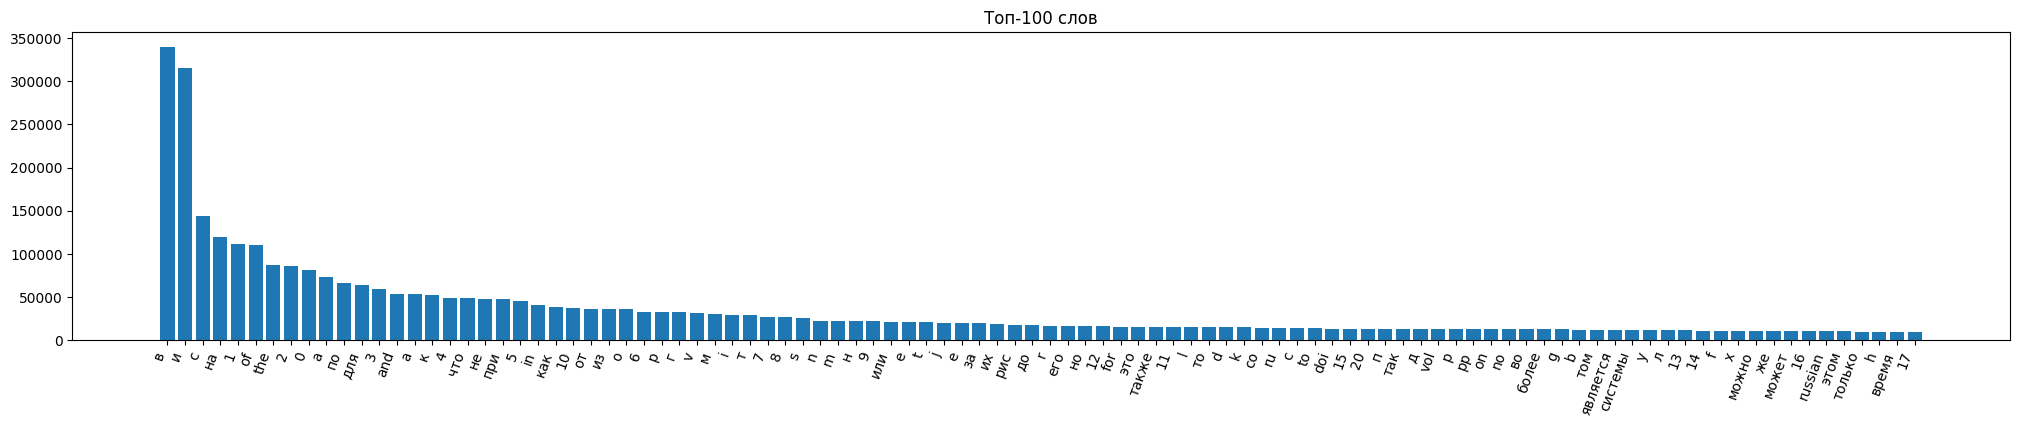

Топ-100 слов:

  1. в                    339906
  2. и                    315527
  3. с                    143392
  4. на                   119249
  5. 1                    111293
  6. of                   109942
  7. the                  86798
  8. 2                    86386
  9. 0                    81655
 10. а                    73265
 11. по                   65726
 12. для                  63386
 13. 3                    58792
 14. and                  53102
 15. a                    52907
 16. к                    52389
 17. 4                    48352
 18. что                  48312
 19. не                   47772
 20. при                  47623
 21. 5                    45873
 22. in                   41039
 23. как                  37949
 24. 10                   37628
 25. от                   36283
 26. из                   36280
 27. о                    36036
 28. 6                    32826
 29. p                    32507
 30. г                    32252
 31. v             

In [6]:
# Извлечение слов из всех статей

def raw_tokens(text):
    return re.findall(r"\w+", str(text).lower())

tokens = []
for article in df["text"].dropna():
    tokens.extend(raw_tokens(article))

# Гистограмма для топ-100 слов

top_n = 100
freq = Counter(tokens).most_common(top_n)
words, counts = zip(*freq)

plt.figure(figsize=(25,4))
plt.bar(words, counts)
plt.xticks(rotation=70, ha="right")
plt.title("Топ-100 слов")
plt.show()

print("Топ-100 слов:\n")
for i, (w, c) in enumerate(zip(words, counts), start=1):
    print(f"{i:3}. {w:<20} {c}")

# Топ пар из 2 слов 

def bigrams(seq):
    a, b = tee(seq)
    next(b, None)
    return zip(a, b)

bigram_freq = Counter(bigrams(tokens)).most_common(50)
print("\nТоп 50-биграмм")
for (w1, w2), c in bigram_freq:
    print(f"{w1} {w2}: {c}")

## Очистка текста

In [ ]:
# Стоп-слова

download("stopwords", quiet=True)
stop_ru = set(stopwords.words("russian"))
stop_en = set(stopwords.words("english"))
custom_stop = {
    # указатели, ссылки
    "doi","org","orcid","http","https","url","удк", 
    # предлоги
    "в","и","с","на","по","для","что","как","от","из","при","но","же","у","о","к",
    # предлоги на англ
    "the","of","in","on","and","a","to","for","is","are",
    # одиночные буквы
    "к","р","п","г","т","е","а","м","н","л","у",
    # цифры
    "0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"
}
custom_bigram_stop = {
    # служебные
    "и в","а также","при этом","а в","на основе","в том","и др","в качестве","так и","что в","не только",
    "но и", "таким образом","том что","том числе","в рамках","в результате","в россии","в виде","в этом",
    "с помощью","на рис",
    # пары чисел
    "1 1","1 2","1 0","2 1","2 2","2 3","2 0",
    "0 0","0 1","0 5","а а","в в","в а",
}
stop_all = stop_ru | stop_en | custom_stop | custom_bigram_stop

morph = pymorphy3.MorphAnalyzer()
english_stemmer = SnowballStemmer("english")

keep_english = True
min_len = 3

# Сохранять кэш слов

lemma_cache: Dict[str, str] = {}
stem_cache: Dict[str, str] = {}

# Наборы шаблон-выражений

URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
EMAIL_RE = re.compile(r"\b[\w.+-]+@[\w-]+\.[\w.-]+\b")
DOI_RE = re.compile(r"\b10\.\d{4,9}/[-._;()/:A-Za-z0-9]+\b", re.IGNORECASE)
ORCID_RE = re.compile(r"\b\d{4}-\d{4}-\d{4}-\d{3}[0-9X]\b")
NUMBER_RE = re.compile(r"\b\d[\d.,/%:-]*\d\b")
TOKEN_RE = re.compile(r"[A-Za-z\u0400-\u04FF]+")
CYRILLIC_RE = re.compile(r"[\u0400-\u04FF]")
LATIN_RE = re.compile(r"[A-Za-z]")

# Функция для очистки по шаблонам

def strip_noise(text: str) -> str:
    text = text.replace("\u00a0", " " ).replace("\ufeff", " " )
    text = URL_RE.sub(" " , text)
    text = EMAIL_RE.sub(" " , text)
    text = DOI_RE.sub(" " , text)
    text = ORCID_RE.sub(" " , text)
    text = NUMBER_RE.sub(" " , text)
    return text

# Функция предобработки текста 

def clean_text(raw: str) -> str:
    text = strip_noise(raw.lower())
    lemmas: list[str] = []
    for token in TOKEN_RE.findall(text):
        if len(token) < min_len:
            continue
        has_cyr = bool(CYRILLIC_RE.search(token))
        has_lat = bool(LATIN_RE.search(token))
        if has_cyr and has_lat:
            continue
        if has_cyr:
            lemma = lemma_cache.get(token)
            if lemma is None:
                lemma = morph.parse(token)[0].normal_form
                lemma_cache[token] = lemma
            if len(lemma) >= min_len and lemma not in stop_all:
                lemmas.append(lemma)
        elif has_lat and keep_english:
            stem = stem_cache.get(token)
            if stem is None:
                stem = english_stemmer.stem(token)
                stem_cache[token] = stem
            if len(stem) >= min_len and stem not in stop_all:
                lemmas.append(stem)
    return " ".join(lemmas)

# Предобработка датасета с помощью функции 

clean_df = (
    df.assign(clean_text=df["text"].map(clean_text))
      .loc[lambda d: d["clean_text"] != ""]
      .reset_index(drop=True)
)

clean_df.head()


,category,file,text,clean_text
0,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,"﻿2011 Компьютерная оптика, том 35, № 2 \n\nАЛГ...",компьютерный оптика алгоритм встраивание полух...
1,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Software & Systems no....,softwar system программный продукт система дат...
2,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Выделение контуров на изображениях с помощью ...,выделение контур изображение помощь алгоритм к...
3,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Программные продукты и системы / Software & S...,программный продукт система softwar system дат...
4,1 Автоматика. Вычислительная техника,russian-scientific-articles\data_3_1\1 Автомат...,﻿Алгоритм поэтапного уточнения проективного пр...,алгоритм поэтапный уточнение проективный преоб...


In [8]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    2457 non-null   object
 1   file        2457 non-null   object
 2   text        2457 non-null   object
 3   clean_text  2457 non-null   object
dtypes: object(4)
memory usage: 76.9+ KB


In [ ]:
clean_df["clean_text"].tolist()

### Визуализация частоты использования очищенных слов

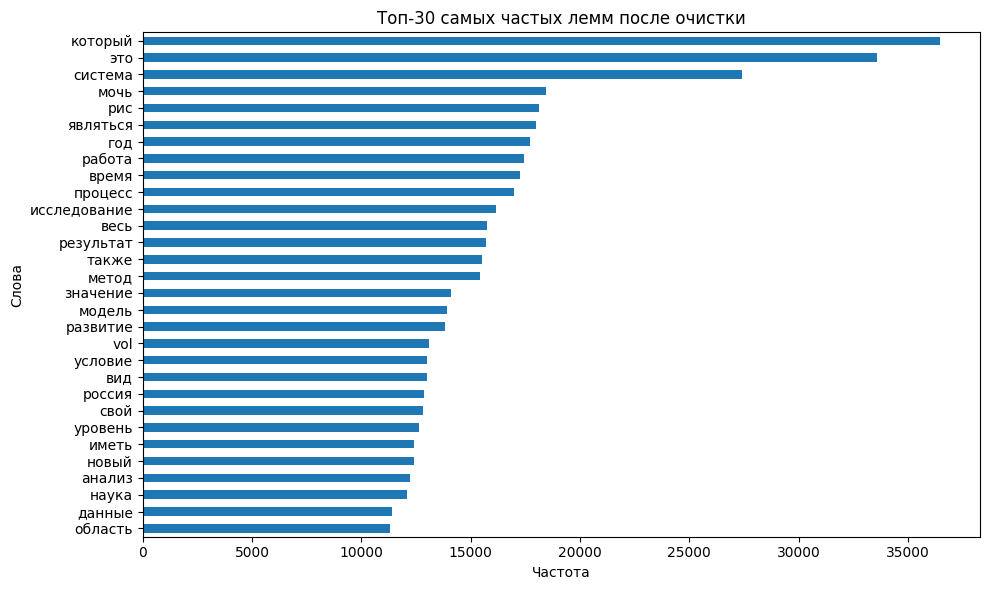

In [54]:
tokens = clean_df["clean_text"].str.split().explode()
freq = tokens.value_counts().head(30)

plt.figure(figsize=(10, 6))
freq.sort_values().plot(kind="barh")
plt.xlabel("Частота")
plt.ylabel("Слова")
plt.title("Топ-30 самых частых лемм после очистки")
plt.tight_layout()
plt.show()

In [9]:
# Сохранение в файл очищенный набор данных
clean_df.to_json("cleaned_dataset.jsonl", orient="records", lines=True, force_ascii=False)

In [ ]:
# Количество статей по рубрикам
category_counts = (clean_df["category"].value_counts().sort_values())

# Вывод столбчатой диаграммы
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(category_counts.index.astype(str), category_counts.values)
ax.set_xlabel("Рубрика")
ax.set_ylabel("Количество статей")
ax.set_title("Распределение статей по рубрикам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# Загрузка набора данных из файла
clean_df = pd.read_json("cleaned_dataset.jsonl", lines=True)
clean_df.head()


# Обучение модели

## Подготовка

In [ ]:
# Разделение на обучающую и валидационную выборку

train_df, test_df = train_test_split(clean_df, test_size=0.2, stratify=clean_df["category"], random_state = 42)

print("Размер train:", train_df.shape)
print("Размер test:", test_df.shape)

Размер train: (1965, 4)
Размер test: (492, 4)


In [55]:
# Векторизация TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), lowercase=False, min_df=2)

train_texts = train_df["clean_text"].tolist()
test_texts = test_df["clean_text"].tolist()

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

y_train = train_df["category"].astype(str).to_numpy()
y_test = test_df["category"].astype(str).to_numpy()

print("Матрица X_train:", X_train.shape)
print("Матрица X_test:", X_test.shape)

# Сохранение векторизатора для будущего использования
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

Матрица X_train: (1965, 5000)
Матрица X_test: (492, 5000)


['tfidf_vectorizer.joblib']

In [56]:
print("NNZ train:", X_train.nnz)
print("Среднее число ненулевых признаков на документ:",
      X_train.nnz / X_train.shape[0])

NNZ train: 1261665
Среднее число ненулевых признаков на документ: 642.0687022900763


In [57]:
# Функция создания пар текстов

def make_pairs(X, y, n_pos=3, n_neg=3, random_state= 42):
    rng = np.random.RandomState(random_state)
    y = np.asarray(y)

    label2idx = defaultdict(list)
    for idx, label in enumerate(y):
        label2idx[label].append(idx)

    all_index = np.arange(len(y))
    pair_i = []
    pair_j = []
    pair_labels = []

    for label, idxs in label2idx.items():
        idxs = np.asarray(idxs)
        other_index = np.setdiff1d(all_index, idxs)

        for i in idxs:
            # положительные пары (та же категория)
            if len(idxs) > 1:
                pos_candidates = idxs[idxs != i]
                n_sample_pos = min(n_pos, len(pos_candidates))
                pos = rng.choice(pos_candidates, size=n_sample_pos, replace=False)
                for j in pos:
                    pair_i.append(i)
                    pair_j.append(j)
                    pair_labels.append(1)

            # отрицательные пары (другая категория)
            if len(other_index) > 0:
                n_sample_neg = min(n_neg, len(other_index))
                neg = rng.choice(other_index, size=n_sample_neg, replace=False)
                for j in neg:
                    pair_i.append(i)
                    pair_j.append(j)
                    pair_labels.append(0)

    pair_i = np.asarray(pair_i)
    pair_j = np.asarray(pair_j)
    pair_labels = np.asarray(pair_labels, dtype=int)

    print(f"Сформировано пар: {len(pair_labels)} "
          f"(положительных: {(pair_labels == 1).sum()}, отрицательных: {(pair_labels == 0).sum()})")

    return pair_i, pair_j, pair_labels


# Формирование обучающих и тестовых пар
train_idx_i, train_idx_j, y_train_pairs = make_pairs(X_train, y_train, n_pos=3, n_neg=3, random_state=42)
test_idx_i, test_idx_j, y_test_pairs = make_pairs(X_test, y_test, n_pos=3, n_neg=3, random_state=42)


Сформировано пар: 11790 (положительных: 5895, отрицательных: 5895)
Сформировано пар: 2946 (положительных: 1470, отрицательных: 1476)


## Проектирование модели

### Модель CosineMLP
Принимает один признак - косинус между векторами пары текстов

In [58]:
class CosineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

In [59]:
# Формирование данных в виде косинуса

def pair_cosine_features(X, idx_i, idx_j):
    idx_i = np.asarray(idx_i)
    idx_j = np.asarray(idx_j)
    sims = []
    for a, b in zip(idx_i, idx_j):
        Xi = X[a]
        Xj = X[b]
        sims.append([cosine_similarity(Xi, Xj)[0, 0]])
    return np.array(sims, dtype="float32")

# Генерация признаков для пар

X_train_pairs = pair_cosine_features(X_train, train_idx_i, train_idx_j)
X_test_pairs  = pair_cosine_features(X_test,  test_idx_i,  test_idx_j)

print("Форма X_train_pairs:", X_train_pairs.shape)
print("Форма X_test_pairs :", X_test_pairs.shape)


Форма X_train_pairs: (11790, 1)
Форма X_test_pairs : (2946, 1)


In [60]:
# Тензоры и dataloader для модели

X_train_cos_t = torch.from_numpy(X_train_pairs)
y_train_cos_t = torch.from_numpy(y_train_pairs.astype("float32")).view(-1, 1)

X_test_cos_t  = torch.from_numpy(X_test_pairs)
y_test_cos_t  = torch.from_numpy(y_test_pairs.astype("float32")).view(-1, 1)

cos_train_ds = TensorDataset(X_train_cos_t, y_train_cos_t)
cos_test_ds  = TensorDataset(X_test_cos_t,  y_test_cos_t)

cos_batch_size = 512

cos_train_loader = DataLoader(cos_train_ds, batch_size=cos_batch_size, shuffle=True)
cos_test_loader  = DataLoader(cos_test_ds,  batch_size=cos_batch_size, shuffle=False)


In [61]:
def train_cosine_model(train_loader, test_loader, device, num_epochs=10):
    model = CosineMLP().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
        "test_auc": []
    }

    best_auc = -1.0
    best_state = None
    patience = 3
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # Обучение
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        # Тестирование
        model.eval()
        test_loss = 0.0
        all_logits = []
        all_targets = []

        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = criterion(logits, yb)
                test_loss += loss.item() * xb.size(0)

                all_logits.append(logits.cpu())
                all_targets.append(yb.cpu())

        test_loss /= len(test_loader.dataset)

        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        proba = torch.sigmoid(all_logits).numpy().reshape(-1)
        true  = all_targets.numpy().reshape(-1)
        pred  = (proba >= 0.5).astype("int32")

        acc = accuracy_score(true, pred)
        auc = roc_auc_score(true, proba)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc)
        history["test_auc"].append(auc)

        print(f"CosineMLP: Эпоха {epoch}: "
              f"train_loss={train_loss:.4f}  test_loss={test_loss:.4f}  "
              f"Точность={acc:.4f}  AUC={auc:.4f}")

        # Early Stop
        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"AUC не улучшался {patience} эпох(и). Остановка обучения.")
                break

    # Загружаются веса с лучшей эпохи
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

# Выполнение
set_seed(42)

cos_model, hist_cos = train_cosine_model(cos_train_loader, cos_test_loader, device, num_epochs=10)


Seed fixed: 42
CosineMLP: Эпоха 1: train_loss=0.7023  test_loss=0.6962  Точность=0.5010  AUC=0.8267
CosineMLP: Эпоха 2: train_loss=0.6929  test_loss=0.6899  Точность=0.5010  AUC=0.8823
CosineMLP: Эпоха 3: train_loss=0.6884  test_loss=0.6862  Точность=0.7179  AUC=0.8823
CosineMLP: Эпоха 4: train_loss=0.6853  test_loss=0.6832  Точность=0.7882  AUC=0.8823
CosineMLP: Эпоха 5: train_loss=0.6819  test_loss=0.6789  Точность=0.8072  AUC=0.8823
CosineMLP: Эпоха 6: train_loss=0.6774  test_loss=0.6742  Точность=0.7797  AUC=0.8823
CosineMLP: Эпоха 7: train_loss=0.6724  test_loss=0.6683  Точность=0.7559  AUC=0.8823
AUC не улучшался 3 эпох(и). Остановка обучения.


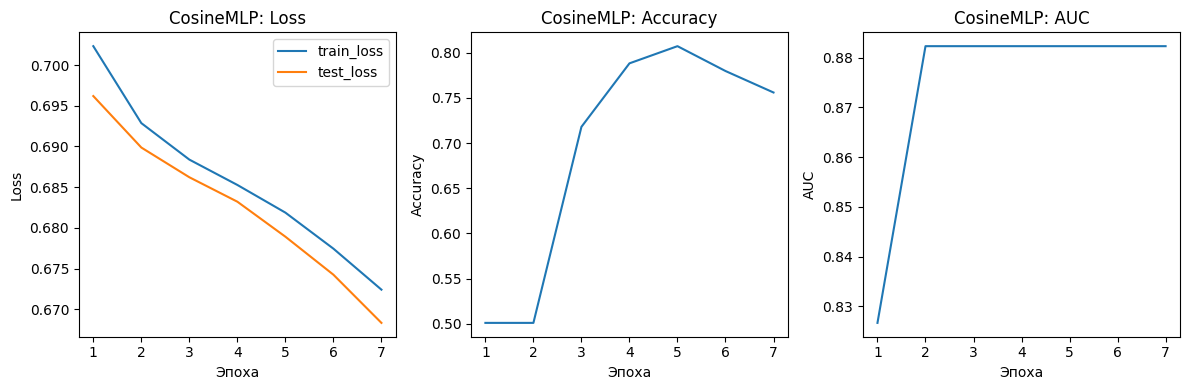

In [62]:
epochs = range(1, len(hist_cos["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_cos["train_loss"], label="train_loss")
plt.plot(epochs, hist_cos["test_loss"], label="test_loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("CosineMLP: Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_cos["test_acc"], label="test_acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("CosineMLP: Accuracy")

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_cos["test_auc"], label="test_auc")
plt.xlabel("Эпоха")
plt.ylabel("AUC")
plt.title("CosineMLP: AUC")

plt.tight_layout()
plt.show()


In [63]:
# Сохранение модели

os.makedirs("models", exist_ok=True)

torch.save(cos_model.state_dict(), "models/cosine_mlp.pt")


# Тестирование

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

# Загрузка TF-IDF векторизатора
vectorizer = joblib.load("tfidf_vectorizer.joblib")

# Определяем размерность TF-IDF-признаков
tfidf_dim = vectorizer.transform(["тестовая строка"]).shape[1]
print("Размерность TF-IDF:", tfidf_dim)

# Загрузка моделей
cos_model = CosineMLP().to(device)
cos_model.load_state_dict(torch.load("models/cosine_mlp.pt", map_location=device))
cos_model.eval()

print("Модели загружены.")

Используемое устройство: cuda
Размерность TF-IDF: 5000
Модели загружены.


In [ ]:
def prepare_tfidf_pair(text1: str, text2: str):
   
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)

    # Если после очистки текст пустой — это крайний случай
    if clean1.strip() == "" or clean2.strip() == "":
        print("Внимание: один из текстов после очистки оказался пустым.")
    
    X_pair = vectorizer.transform([clean1, clean2])  # (2, tfidf_dim)
    x1 = X_pair[0]
    x2 = X_pair[1]
    return x1, x2, clean1, clean2

In [ ]:
def predict_with_cosine_mlp(text1: str, text2: str, threshold: float = 0.5):

    x1, x2, clean1, clean2 = prepare_tfidf_pair(text1, text2)

    # Косинусное сходство между TF-IDF векторами
    cos = float(cosine_similarity(x1, x2)[0, 0])

    # Преобразуем в тензор формы (1, 1)
    inp = torch.tensor([[cos]], dtype=torch.float32, device=device)

    cos_model.eval()
    with torch.no_grad():
        logit = cos_model(inp)
        prob = torch.sigmoid(logit).item()

    label = int(prob >= threshold)
    return prob, label, cos


In [68]:
# Пример: пользователь вводит два текста
text_a = input("Введите первый текст:\n")
text_b = input("\nВведите второй текст:\n")

print("\nИспользуется модель: CosineMLP")
prob_cos, label_cos, cos = predict_with_cosine_mlp(text_a, text_b)
print(f"Косинусное сходство: {cos:.4f}")
print(f"Вероятность схожести: {prob_cos:.4f}")
print("Решение:", "Похожие" if label_cos == 1 else "Не похожие")


Используется модель: CosineMLP
Косинусное сходство: 0.0000
Вероятность схожести: 0.4903
Решение: Не похожие
